## Using Yelp Open Dataset

##### Currently, users' opinions about a particular restaurant on Yelp are heavily influenced by only a few aspects displayed on the business's yelp page. Here are just a few:

1. Number of reviews on the restaurant
2. The overall rating of the restaurant (out of 5 stars)
3. Photos
4. The top listed reviews picked by Yelp
5. Popular dishes

Despite Yelp's attempt to give users an overview of what the restaurant is like, it is still a very cumbersome job for users to browser through all these information and make an informed decision which yields a positive experience for the user overall.


This project is an attempt to increase overall user experience by analyzing all of a restaurant's reviews and summarizing the main topics in a form of unigram adjectives clouds describing each of the main topics. 

In [4]:
import pandas as pd, numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
yelp_df.city.value_counts()

Toronto       7965
Las Vegas     6455
Phoenix       4004
Montréal      3784
Calgary       2912
Charlotte     2711
Pittsburgh    2454
Name: city, dtype: int64

In [5]:
yelp_df.reset_index(inplace = True, drop=True)
yelp_df.shape

(30285, 307)

In [6]:
restaurant_review = yelp_df[['name', 'text']]

#### Text Preprocessing

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.stem import PorterStemmer 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bentleyou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [68]:
# put all the reviews to a list
reviews = [review for review in restaurant_review['text']]

In [69]:
# tokenize all the words in each review and store it into a list
texts = [[text for text in review.split()] for review in reviews]

In [ ]:
# use lemmatization and stemming to convert similar meaning words to a single words
lemmatizer = WordNetLemmatizer()

lemmatized_reviews = []

for n in texts:
    lemmatized_reviews.append(' '.join([lemmatizer.lemmatize(w) for w in n]))

In [70]:
# use lemmatization and stemming to convert similar meaning words to a single words
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer() 

lemmatized_reviews = []

for n in texts:
    lemmatized_reviews.append(' '.join([ps.stem(lemmatizer.lemmatize(w)) for w in n]))

#### Pickle Checkpoint for preprocessed reviews

In [9]:
import pickle
# with open("./Data/preprocessed_reviews.txt", "wb") as fp:   #Pickling
#     pickle.dump(lemmatized_reviews, fp)

In [6]:
# with open("./Data/preprocessed_reviews.txt", "rb") as fp:   # Unpickling
#     preprocessed_reviews = pickle.load(fp)

#### Vectorize the review corpus using TF-IDF

1. TF is the term frequency (normalized). We want to increase the importances of terms that shows up more in a document to matter more. But this is unfair for longer reviews, thus we normalize it.

2. Secondly, IDF is the inverse document frequency because we want to decrease the relevance of the same terms that show up across many documents but increase the relevance of the rarer terms. The logarithmic transformation resolve this.

TF-IDF produces a restaurant (rows) and word (cols) matrix

In [17]:
Tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1), 
                                   min_df = 3)
doc_word = Tfidf_vectorizer.fit_transform(preprocessed_reviews)
doc_word.shape

NameError: name 'preprocessed_reviews' is not defined

In [27]:
Tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=3, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

#### Pickle TF-IDF vectorizer model

In [76]:
with open("./Recommendation_Engine/Tfidf.pkl", "wb") as fp:   #Pickling
    pickle.dump(Tfidf_vectorizer, fp)

In [10]:
with open("../Recommendation_Engine/Tfidf.pkl", "rb") as fp:   # Unpickling
    Tfidf_vectorizer = pickle.load(fp)

#### Dimensionality Reduction

#### LSA model

In [29]:
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(doc_word)
sum(lsa.explained_variance_ratio_)

0.1698760617909907

In [34]:
variance = []
for n in range(1,20):
    lsa_mod = TruncatedSVD(n)
    lsa_mod.fit_transform(doc_word)
    variance.append(sum(lsa_mod.explained_variance_ratio_))

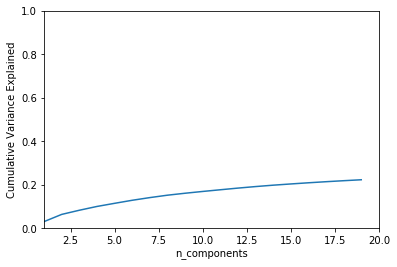

In [46]:
plt.figure(figsize = (6,4))
sns.lineplot(range(1,20), variance)
plt.ylim([0,1]);
plt.xlim([1,20]);
# plt.title();
plt.xlabel('n_components')
plt.ylabel('Cumulative Variance Explained')
plt.savefig('Total_variance_explained_LSA.png')

In [16]:
with open("../Recommendation_Engine/lsa_model.pkl", "wb") as fp:   #Pickling
    pickle.dump(lsa, fp)
    
with open("../Recommendation_Engine/lsa_model.pkl", "rb") as fp:   # Unpickling
    lsa = pickle.load(fp)
doc_topic_lsa = lsa.fit_transform(doc_word)

NameError: name 'doc_word' is not defined

In [80]:
doc_topic_lsa = pd.DataFrame(doc_topic_lsa, index = yelp_df['name'])
doc_topic_lsa.reset_index(inplace = True)
doc_topic_lsa['city'] = yelp_df['city']
doc_topic_lsa.set_index('name', inplace = True)

doc_topic_lsa.to_pickle('./Recommendation_Engine/doc_topic_lsa.pkl')

In [81]:
doc_topic_lsa.head()

,0,1,2,3,4,5,6,7,8,9,city
name,,,,,,,,,,,
Musashi Japanese Restaurant,0.465727,-0.097584,0.407637,-0.098822,-0.040383,0.065129,0.018685,0.006019,0.011766,-0.017761,Charlotte
Taco Bell,0.434946,-0.014908,-0.105627,-0.083963,0.277239,0.295453,-0.139237,0.056019,0.014514,-0.001800,Phoenix
Carluccio's Tivoli Gardens,0.467667,-0.027968,-0.022786,0.024090,-0.034207,-0.037951,-0.085192,-0.013680,-0.007526,-0.009368,Las Vegas
Marathon Diner,0.471496,-0.023915,-0.075306,-0.009050,-0.030503,0.007930,0.075372,-0.080971,-0.075043,-0.047618,Pittsburgh
Maria's Mexican Restaurant & Bakery,0.649114,-0.092932,-0.073829,-0.074755,0.273695,0.180593,-0.171728,0.034240,0.026673,0.004204,Las Vegas


#### NMF model

In [82]:
nmf = NMF(10)
doc_topic = nmf.fit_transform(doc_word)
doc_topic.shape

(30285, 10)

In [11]:
nmf = pd.read_pickle('../Recommendation_Engine/nmf_model.pkl')
lsa = pd.read_pickle('../Recommendation_Engine/lsa_model.pkl')

In [12]:
sum(lsa.explained_variance_ratio_)

0.16987720693546696

In [13]:
sum(nmf.explained_variance_ratio_)

0.16987720693546696

In [14]:
# with open("./Recommendation_Engine/nmf_model.pkl", "wb") as fp:   #Pickling
#     pickle.dump(lsa, fp)
    
with open("../Recommendation_Engine/nmf_model.pkl", "rb") as fp:   # Unpickling
    nmf = pickle.load(fp)
    
doc_topic_nmf = nmf.fit_transform(doc_word)

NameError: name 'doc_word' is not defined

In [1]:
doc_topic_nmf = pd.DataFrame(doc_topic_nmf, index = yelp_df['name'])
doc_topic_nmf.reset_index(inplace = True)
doc_topic_nmf['city'] = yelp_df['city']
doc_topic_nmf.set_index('name', inplace = True)

# doc_topic_nmf.to_pickle('./Recommendation_Engine/doc_topic_nmf.pkl')

NameError: name 'pd' is not defined

In [72]:
def find_similarity_LSA(search, top_search, location):
    
    string_word = Tfidf_vectorizer.transform([search])
    print(string_word.shape)
    
    string_topic = lsa.transform(string_word)
    
    print(string_topic.shape)
    
    cosine_list = []
    print(cosine_list)
    
    location_res_topic = doc_topic_lsa[doc_topic_lsa['city'] == location].iloc[:,0:5]
    restaurant_topic_array = location_res_topic.values
    restaurant_index = location_res_topic.index
    
    print(restaurant_topic_array.shape)
    
    for restaurant in restaurant_topic_array:
        
        cosine_list.append(cosine_similarity([restaurant,string_topic.reshape(-1)])[1][0])
    
    cosine_array = np.array(cosine_list)
    
    restaurant_sim = pd.DataFrame(cosine_array, 
                                  index = restaurant_index,
                                 columns = ['Similarity']).sort_values(by = 'Similarity', 
                                                                       ascending = False)
    return restaurant_sim[:top_search]